<a href="https://colab.research.google.com/github/kjcoursera/TensorFlow/blob/main/Intro_neural_nets_CA_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Tensor Flow and helper libraries**

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.0


**Training and Test Dataset**

In [3]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
#shuffle the training dataset
train_df = train_df.reindex(np.random.permutation(train_df.index))

test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")


**Normalize Values**

In [4]:
#Normalize the train_df
train_df_mean = train_df.mean()
train_df_std = train_df.std()

train_df_norm = (train_df-train_df_mean)/train_df_std

train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
15032,-1.340483,1.059623,1.065442,0.100615,-0.188401,-0.347234,-0.138411,1.483223,1.390704
10733,-0.537557,-0.222344,-1.715219,2.421314,2.141377,1.248789,1.809468,0.505945,0.583695
4905,0.729171,-0.802504,0.906547,-0.977393,-1.042494,-0.897827,-1.046034,0.519571,-0.342297
2720,0.933642,-0.737002,-1.476877,-0.352607,-0.411414,-0.326326,-0.359465,0.232068,-0.675965
3880,0.803977,-0.849292,0.350415,-0.421875,-0.589350,-0.423899,-0.562315,0.646919,-0.104333


In [5]:
#normalize test_df
test_df_mean = test_df.mean()
test_df_std = test_df.std()

test_df_norm = (test_df-test_df_mean)/test_df_std

**Represent Data**

In [8]:
# Create an empty list that will hold all feature columns
feature_columns = []
resolution_in_Zs = 0.3 # 3/10
# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df_norm['latitude'])), 
                                     int(max(train_df_norm['latitude'])), 
                                     resolution_in_Zs))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)


# Create a bucket feature column for longitude
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df_norm["longitude"])),
                                     int(max(train_df_norm["longitude"])),
                                     resolution_in_Zs))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column,longitude_boundaries)

#Create a feature cross of latitude and longitude
latitude_X_longitude = tf.feature_column.crossed_column([latitude,longitude], hash_bucket_size = 100)
crossed_feature = tf.feature_column.indicator_column(latitude_X_longitude)
feature_columns.append(crossed_feature)

# Represent median_income as a floating-point value.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Represent population as a floating-point value.
population = tf.feature_column.numeric_column("population")
feature_columns.append(population)

# Convert the list of feature columns into a layer that will later be fed into
# the model.
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

**Plotting**

In [9]:
def plot_the_loss_curve(epochs, mse):
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")
  plt.plot(epochs,mse, label="Loss")
  plt.legend()
  
  plt.show()
  return

***Linear Model***

In [10]:
# Linear model
def create_model(my_learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model           


def train_model(model, dataset, epochs, batch_size, label_name):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist["mean_squared_error"]

  return epochs, rmse   

#print("Defined the create_model and train_model functions.")

Epoch 1/15
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 0s 2ms/step - loss: 1.0013 - mean_squared_error: 1.0013
Epoch 2/15
17/17 [==============================] - 0s 2ms/step - loss: 0.6798 - mean_squared_error: 0.6798
Epoch 3/15
17/17 [==============================] - 0s 2ms/step - loss: 0.5129 - mean_squared_error: 0.5129
Epoch 4/15
17/17 [==============================] - 0s 2ms/step - loss: 0.4202 - mean_squared_error: 0.4202
Epoch 5/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3771 - mean_squared_error: 0.3771
Epoch 6/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3630 - mean_squared_error: 0.3630
Epoch 7/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3606 - mean_squared_error: 0.3606
Epoch 8/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3603 - mean_squared_error: 0.3603
Epoch 9/15
17/17 [========

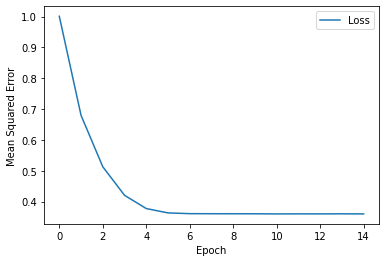


 Evaluate the linear regression model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 5ms/step - loss: 0.3955 - mean_squared_error: 0.3955
[0.39549970626831055, 0.39549970626831055]


In [14]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined by the feature_layer.

epochs, mse = train_model(my_model, train_df_norm, epochs, batch_size, label_name)
plot_the_loss_curve(epochs, mse)
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
linear_mse = my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)
print(linear_mse)

**Deep neural net model**

In [15]:
def create_model(my_learning_rate, my_feature_layer):
  model = tf.keras.models.Sequential()
  model.add(my_feature_layer)
  # Define the first hidden layer with 20 nodes.   
  model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu', 
                                  name='Hidden1'))
   # Define the second hidden layer with 12 nodes.
  model.add(tf.keras.layers.Dense(units=12, 
                                  activation='relu', 
                                  name='Hidden2'))
   # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1, name='Output'))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                 loss="mean_squared_error",
                 metrics=[tf.keras.metrics.MeanSquaredError()])
  return model

   

In [16]:
def train_model(model, dataset, epochs, label_name, batch_size=None):
  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle = True)
  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  
  mse = hist["mean_squared_error"]

  return epochs, mse

  


Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 0s 3ms/step - loss: 0.6086 - mean_squared_error: 0.6086
Epoch 2/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3671 - mean_squared_error: 0.3671
Epoch 3/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3440 - mean_squared_error: 0.3440
Epoch 4/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3379 - mean_squared_error: 0.3379
Epoch 5/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3345 - mean_squared_error: 0.3345
Epoch 6/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3317 - mean_squared_error: 0.3317
Epoch 7/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3318 - mean_squared_error: 0.3318
Epoch 8/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3300 - mean_squared_error: 0.3300
Epoch 9/20
17/17 [========

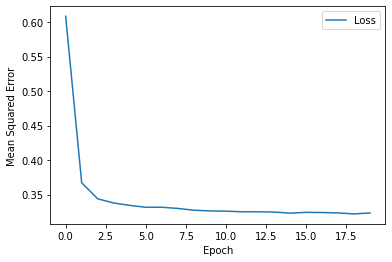


 Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 3ms/step - loss: 0.3662 - mean_squared_error: 0.3662
linear mse: [0.39549970626831055, 0.39549970626831055]
neural net mse: [0.36623239517211914, 0.36623239517211914]


In [18]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 20
batch_size = 1000
# Specify the label
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined by the feature_layer.
epochs, mse  = train_model(my_model, train_df_norm, epochs, 
                          label_name, batch_size)
plot_the_loss_curve(epochs, mse)

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
nn_mse = my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)
print("linear mse:" ,linear_mse)
print("neural net mse:", nn_mse)


***Optimize the deep neural network's topography***

In [66]:
def create_model(my_learning_rate, my_feature_layer):
  model = tf.keras.models.Sequential()
  model.add(my_feature_layer)
  # Define the first hidden layer with 20 nodes.   
  model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu', 
                                  name='Hidden1'))
   # Define the second hidden layer with 10 nodes.
  model.add(tf.keras.layers.Dense(units=10, 
                                  activation='relu', 
                                  name='Hidden2'))
   # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1, name='Output'))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                 loss="mean_squared_error",
                 metrics=[tf.keras.metrics.MeanSquaredError()])
  return model


Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 0s 4ms/step - loss: 0.6177 - mean_squared_error: 0.6177
Epoch 2/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3747 - mean_squared_error: 0.3747
Epoch 3/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3465 - mean_squared_error: 0.3465
Epoch 4/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3391 - mean_squared_error: 0.3391
Epoch 5/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3372 - mean_squared_error: 0.3372
Epoch 6/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3344 - mean_squared_error: 0.3344
Epoch 7/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3346 - mean_squared_error: 0.3346
Epoch 8/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3333 - mean_squared_error: 0.3333
Epoch 9/20
17/17 [========

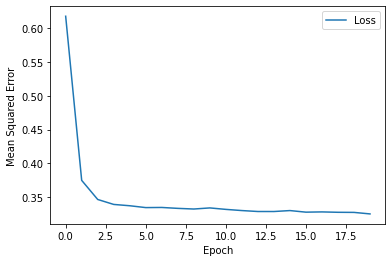


 Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 3ms/step - loss: 0.3659 - mean_squared_error: 0.3659
linear mse: [0.39549970626831055, 0.39549970626831055]
neural net mse: [0.36623239517211914, 0.36623239517211914]
Optimize neural net mse: [0.36585304141044617, 0.36585304141044617]


In [67]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 20
batch_size = 1000
# Specify the label
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined by the feature_layer.
epochs, mse  = train_model(my_model, train_df_norm, epochs, 
                          label_name, batch_size)
plot_the_loss_curve(epochs, mse)

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
op_nn_mse = my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)
print("linear mse:" ,linear_mse)
print("neural net mse:", nn_mse)
print("Optimize neural net mse:", op_nn_mse)


**L2 regularization**

In [96]:
def create_model(my_learning_rate, my_feature_layer):
  model = tf.keras.models.Sequential()
  model.add(my_feature_layer)
  # Define the first hidden layer with 20 nodes.   
  model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu', 
                                  kernel_regularizer=tf.keras.regularizers.L2(l=0),
                                  name='Hidden1'))

   # Define the second hidden layer with 10 nodes.
  model.add(tf.keras.layers.Dense(units=10, 
                                  activation='relu', 
                                  kernel_regularizer=tf.keras.regularizers.L2(l=0.1),
                                  name='Hidden2'))
   # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1, name='Output'))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                 loss="mean_squared_error",
                 metrics=[tf.keras.metrics.MeanSquaredError()])
  return model


Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 0s 3ms/step - loss: 1.4150 - mean_squared_error: 0.5907
Epoch 2/20
17/17 [==============================] - 0s 3ms/step - loss: 0.5950 - mean_squared_error: 0.3767
Epoch 3/20
17/17 [==============================] - 0s 3ms/step - loss: 0.4061 - mean_squared_error: 0.3522
Epoch 4/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3689 - mean_squared_error: 0.3445
Epoch 5/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3582 - mean_squared_error: 0.3401
Epoch 6/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3553 - mean_squared_error: 0.3408
Epoch 7/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3507 - mean_squared_error: 0.3380
Epoch 8/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3535 - mean_squared_error: 0.3423
Epoch 9/20
17/17 [========

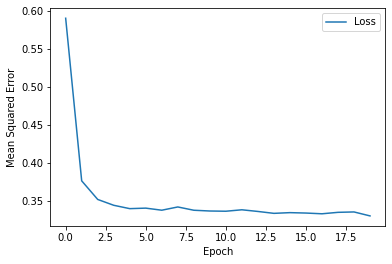


 Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 4ms/step - loss: 0.3768 - mean_squared_error: 0.3697
linear mse: [0.39549970626831055, 0.39549970626831055]
neural net mse: [0.36623239517211914, 0.36623239517211914]
Optimize neural net mse: [0.36585304141044617, 0.36585304141044617]
L2:Optimize neural net mse: [0.3768382966518402, 0.36966273188591003]


In [97]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 20
batch_size = 1000
# Specify the label
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined by the feature_layer.
epochs, mse  = train_model(my_model, train_df_norm, epochs, 
                          label_name, batch_size)
plot_the_loss_curve(epochs, mse)

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
op_L2_nn_mse = my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)
print("linear mse:" ,linear_mse)
print("neural net mse:", nn_mse)
print("Optimize neural net mse:", op_nn_mse)
print("L2:Optimize neural net mse:", op_L2_nn_mse)

**L1 Regularization**

In [101]:
def create_model(my_learning_rate, my_feature_layer):
  model = tf.keras.models.Sequential()
  model.add(my_feature_layer)
  # Define the first hidden layer with 20 nodes.   
  model.add(tf.keras.layers.Dense(units=20, 
                                  activation= 'relu', 
                                  kernel_regularizer=tf.keras.regularizers.L1(l=0),
                                  name='Hidden1'))

   # Define the second hidden layer with 10 nodes.
  model.add(tf.keras.layers.Dense(units=10, 
                                  activation='relu', 
                                  kernel_regularizer=tf.keras.regularizers.L1(l=0),
                                  name='Hidden2'))
   # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1, name='Output'))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                 loss="mean_squared_error",
                 metrics=[tf.keras.metrics.MeanSquaredError()])
  return model


Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 0s 3ms/step - loss: 0.5718 - mean_squared_error: 0.5718
Epoch 2/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3707 - mean_squared_error: 0.3707
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3441 - mean_squared_error: 0.3441
Epoch 4/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3376 - mean_squared_error: 0.3376
Epoch 5/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3336 - mean_squared_error: 0.3336
Epoch 6/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3307 - mean_squared_error: 0.3307
Epoch 7/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3295 - mean_squared_error: 0.3295
Epoch 8/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3262 - mean_squared_error: 0.3262
Epoch 9/20
17/17 [========

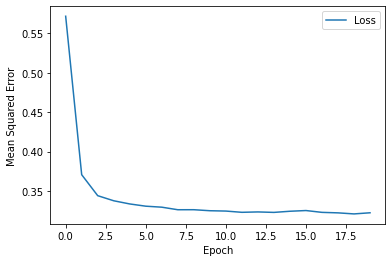


 Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 3ms/step - loss: 0.3640 - mean_squared_error: 0.3640
linear mse: [0.39549970626831055, 0.39549970626831055]
neural net mse: [0.36623239517211914, 0.36623239517211914]
Optimize neural net mse: [0.36585304141044617, 0.36585304141044617]
L2:Optimize neural net mse: [0.3768382966518402, 0.36966273188591003]
L1:Optimize neural net mse: [0.3639865219593048, 0.3639865219593048]


In [102]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 20
batch_size = 1000
# Specify the label
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined by the feature_layer.
epochs, mse  = train_model(my_model, train_df_norm, epochs, 
                          label_name, batch_size)
plot_the_loss_curve(epochs, mse)

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
op_L1_nn_mse = my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)
print("linear mse:" ,linear_mse)
print("neural net mse:", nn_mse)
print("Optimize neural net mse:", op_nn_mse)
print("L2:Optimize neural net mse:", op_L2_nn_mse)
print("L1:Optimize neural net mse:", op_L1_nn_mse)